# Classification with KNN 

For constructing a KNN classificator, it is necessary to define a distance metric. Being the one giving best results in clusters, we will use the custom metric.  
Being some attributes categorical, we could try to implement the MVDM distance metric for categorical attributes:  
$$d(V_1,V_2) = \sum_i|\frac{n_{1i}}{n_1} - \frac{n_{2i}}{n_2}| $$  
Where: 
- $n_1$, $n_2$ is the number of data objects having 1 as categorical attribute;
- $n_{1i}$, $n_{2i}$ is the number of attribute of label $i$ and attribute 1,2.  

This can be useful for attributes such as `time_signature`, but being the possible values 3 and being reasonable using the jaccard measure (the attributes can be considered nominal, even if they have some numerical value), it makes no sense to implement some different measure (think about it). 



## Data transformation
Before starting with classification, we will transform data and normalize in order to compute distances. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [33]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

In [58]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [34]:
# importing datasets - one will be used for training, one for testing.
df_original_copy_training = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df_train = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

df_test = pd.read_csv("dataset (missing + split)/test.csv", skipinitialspace=True)

In [35]:
#Changing udm to duration_ms and features_duration_ms from ms to min - train
df_train['duration_ms'] *= 1/6e4
#Changing udm to duration_ms and features_duration_ms from ms to min - test
df_test['duration_ms'] *= 1/6e4
#Setting popularity as a % - train
df_train['popularity'] /= 100
df_train.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_train.rename(columns = {'popularity':'popularity_percent'}, inplace = True)
#Setting popularity as a % - test
df_test['popularity'] /= 100
df_test.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df_test.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

### Filling of NaN values

In [36]:
#Dealing with mode attribute missing values - train
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_train['mode'].value_counts()[0]/(len(df_train)-df_train['mode'].isnull().sum())
p1=df_train['mode'].value_counts()[1]/(len(df_train)-df_train['mode'].isnull().sum())
list_of_nan_indexes_train=df_train[df_train['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_train:
    if np.random.random() < p1:
        df_train.loc[i,'mode'] = 1.0
    else:
        df_train.loc[i,'mode'] = 0.0
        
#Dealing with mode attribute missing values - test
#Computing p0 and p1 and filling missing values of mode attribute by sampling

p0=df_test['mode'].value_counts()[0]/(len(df_test)-df_test['mode'].isnull().sum())
p1=df_test['mode'].value_counts()[1]/(len(df_test)-df_test['mode'].isnull().sum())
list_of_nan_indexes_test=df_test[df_test['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes_test:
    if np.random.random() < p1:
        df_test.loc[i,'mode'] = 1.0
    else:
        df_test.loc[i,'mode'] = 0.0

In [37]:
#Dealing with time_signature attribute missing values - train
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_train['time_signature'].value_counts())
p_array=np.array(df_train['time_signature'].value_counts().sort_index(ascending=True)/(len(df_train)-df_train['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_train[df_train['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_train.loc[i,'time_signature'] = dict_ts[index]
    
#Dealing with time_signature attribute missing values - test
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df_test['time_signature'].value_counts())
p_array=np.array(df_test['time_signature'].value_counts().sort_index(ascending=True)/(len(df_test)-df_test['time_signature'].isnull().sum()))
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df_test[df_test['time_signature'].isnull()].index.tolist()
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df_test.loc[i,'time_signature'] = dict_ts[index]

Let's check if everything is fine

In [38]:
df_train.isnull().sum()

name                         0
duration_min                 0
explicit                     0
popularity_percent           0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [39]:
df_test.isnull().sum()

name                        0
duration_min                0
explicit                    0
popularity_percent          0
artists                     0
album_name                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
features_duration_ms        0
time_signature              0
n_beats                     0
n_bars                      0
popularity_confidence    4279
processing                  0
genre                       0
dtype: int64

In [40]:
df_train['genre'].value_counts()

genre
j-dance          750
iranian          750
brazil           750
chicago-house    750
forro            750
idm              750
indian           750
study            750
disney           750
afrobeat         750
mandopop         750
techno           750
sleep            750
spanish          750
j-idol           750
industrial       750
happy            750
bluegrass        750
black-metal      750
breakbeat        750
Name: count, dtype: int64

In [41]:
df_test['genre'].value_counts()

genre
industrial       250
breakbeat        250
happy            250
afrobeat         250
study            250
black-metal      250
sleep            250
bluegrass        250
techno           250
brazil           250
j-dance          250
chicago-house    250
disney           250
iranian          250
mandopop         250
idm              250
spanish          250
j-idol           250
indian           250
forro            250
Name: count, dtype: int64

Pay attention, in train and test sets, genra does not have same order, it is necessary to use a dictionary map for BOTH. 

### Outlier criteria
For now, we do not consider any point as outlier because none of them miss the classification label and considering that this time one of our tasks is to distinguish between musical genra and not-musical genra. 

### Eliminating redundant features

In [42]:
df_train.dtypes

name                      object
duration_min             float64
explicit                    bool
popularity_percent       float64
artists                   object
album_name                object
danceability             float64
energy                   float64
key                        int64
loudness                 float64
mode                     float64
speechiness              float64
acousticness             float64
instrumentalness         float64
liveness                 float64
valence                  float64
tempo                    float64
features_duration_ms       int64
time_signature           float64
n_beats                  float64
n_bars                   float64
popularity_confidence    float64
processing               float64
genre                     object
dtype: object

In [43]:
#cols that gives max complexity or that are highly correlated
column2drop = ['features_duration_ms', 'popularity_confidence', 'processing', 'name', 'artists','album_name', 'n_bars', 'n_beats'] 
df_train.drop(column2drop, axis=1, inplace=True)
df_test.drop(column2drop, axis=1, inplace=True)

In [44]:
#Reindexing columns just for defining in an easier manner the custom metric
column_names = ['genre','key','duration_min', 'danceability','energy','speechiness', 'acousticness',
       'instrumentalness','tempo','mode','time_signature']


df_train = df_train.reindex(columns=column_names)
df_train.columns

Index(['genre', 'key', 'duration_min', 'danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'tempo', 'mode', 'time_signature'],
      dtype='object')

In [45]:
df_train.head()

,genre,key,duration_min,danceability,energy,speechiness,acousticness,instrumentalness,tempo,mode,time_signature
0,j-dance,5,4.029333,0.690,0.513,0.0975,0.302000,0.53600,142.221,1.0,4.0
1,iranian,1,7.400000,0.069,0.196,0.0805,0.283000,0.93400,75.596,0.0,4.0
2,black-metal,2,5.558433,0.363,0.854,0.0397,0.000089,0.80000,116.628,1.0,4.0
3,bluegrass,5,4.496667,0.523,0.585,0.0765,0.066400,0.00127,140.880,1.0,4.0
4,happy,7,5.127517,0.643,0.687,0.0539,0.000576,0.09690,143.956,1.0,4.0


### Encoding `str` values - creating the various `genre` maps
- first map: 20 classes, one for every genre;
- second map: regrouping per macro genre with the following labels:  

| Label | Macro genre | `genre` list |
| ----------- | ----------- | -------------------------------------------------------------|
| 0 | Electronic | `breakbeat`, `chicago house`, `techno`, `afrobeat`, `idm` , `industrial`|
| 1 | Pop + Asian| `mandopop`,`j-idol`,`happy`,`disney`,`j-dance`, `indian`|
| 2 | Latin | `forro`,`brazil`,`spanish`|
| 3 | Country | `bluegrass`|
| 4 | Metal | `black metal`|
| 5 | Iranian | `iranian`|
| 6 | Others | `sleep`, `study`|

In [46]:
#Creating genre map I -> mapping every genre into an int value in order to have correlation values. 
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
#Creating genre map II -> mapping in macro-categories as described above
macrogenre_map={"j-dance":1,"iranian":5,"brazil":2,"chicago-house":0,"forro":2,"idm":0,"indian":1,"study":6,"disney":1,"afrobeat":0,"mandopop":1,"techno":0,"sleep":6,"spanish":2,"j-idol":1,"industrial":0,"happy":1,"bluegrass":3,"black-metal":4,"breakbeat":0}

#aa

NB: here _partitioning_ is not necessary because both train and test sets are already equally partitioned (so,holdout is not performed).

## First genre map - all genra

### Data normalization - performing _minmax_ normalization

In [47]:
#Saving a variable containing all non-classification attributes
attributes = [col for col in df_train.columns if col != 'genre']

In [48]:
df_train.replace({'genre':genre_map}, inplace=True)
df_test.replace({'genre':genre_map}, inplace=True)

In [49]:
#genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
X_train = df_train[attributes].values
X_test = df_test[attributes].values

y_train = np.array(df_train['genre'])
y_test = np.array(df_test['genre'])

In [50]:
y_train

array([ 0,  1, 18, ..., 11, 19,  6])

In [143]:
#performing minmax normalization 
scaler = MinMaxScaler()
X_minmax_train = scaler.fit_transform(X_train)
X_minmax_test = scaler.fit_transform(X_test)
#Now we have the two dataset

#### Defining the custom metric

In [26]:
from scipy.spatial.distance import seuclidean, jaccard
# Defining the metric
# key has a custom metric due to its circular shape 
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. 

def custom_dist_key(x1, x2):
    index_key = 0
    index_con = 9
    
    c = 0.09090909
    #print("x1 key", x1[index_key])
    #print("x2 key", x2[index_key])
    diff = abs(x1[index_key] - x2[index_key]) / c
    diff_key = (min(12 - diff, diff) * c)
    
    #print("diff key", diff_key)
    
    d_con = seuclidean(x1[index_key+1:index_con], x2[index_key+1:index_con], V=np.ones(index_con - 1))
    d_cat = jaccard(x1[index_con:], x2[index_con:])
    
    #print("x1 con", x1[index_key+1:index_con])
    #print("x2 con", x2[index_key+1:index_con])
    #print("d_con", d_con)
    
    #print("x1 cat", x1[index_con:])
    #print("x2 cat", x2[index_con:])
    #print("d_cat", d_cat)
    
    return diff_key + d_con + d_cat

In [27]:
#computing the distance matrices - starting with custom distance
D_train = pdist(X_minmax_train, custom_dist_key)
D_train = squareform(D_train)

D_test = pdist(X_minmax_test, custom_dist_key)
D_test = squareform(D_test)

In [29]:
from sklearn.neighbors import KNeighborsClassifier

#### Hyperparameters tuning

The tunable parameters are: 
- distance metric, here we consider only `precomputed` (that is, our custom metric). 
- number of nearest neighbours k;
- type of weights: `uniform` or `distance`.
We can do a gridsearch. I don't know if grid and not randomized is fine.  

After having found the best knn classifier, we will evaluate the performances, doing the following:
- performance evaluation using cross validation _on training set_;
- performance evaluation _on test set_.

In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

We decide to span the search for `n_neighbors` in [2,$\sqrt{N}$], that is the suggested value given by rule of thumb for classificators. Before proceding with the search, we consider the trend varying only this parameter. 

In [140]:
k_nn_trials = np.arange(1, int(np.sqrt(len(X_minmax_train)))+1)
#k_nn_trials = np.append(k_nn_trials, np.arange(50, 150, 10))
print(k_nn_trials)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122]


Evaluating performances of KNN with n_neighbors = 1
Evaluating performances of KNN with n_neighbors = 1, the score is: 0.9999333333333333
Evaluating performances of KNN with n_neighbors = 2
Evaluating performances of KNN with n_neighbors = 2, the score is: 0.6420666666666667
Evaluating performances of KNN with n_neighbors = 3
Evaluating performances of KNN with n_neighbors = 3, the score is: 0.5632666666666667
Evaluating performances of KNN with n_neighbors = 4
Evaluating performances of KNN with n_neighbors = 4, the score is: 0.5293333333333333
Evaluating performances of KNN with n_neighbors = 5
Evaluating performances of KNN with n_neighbors = 5, the score is: 0.5014
Evaluating performances of KNN with n_neighbors = 6
Evaluating performances of KNN with n_neighbors = 6, the score is: 0.4842
Evaluating performances of KNN with n_neighbors = 7
Evaluating performances of KNN with n_neighbors = 7, the score is: 0.4694
Evaluating performances of KNN with n_neighbors = 8
Evaluating perform

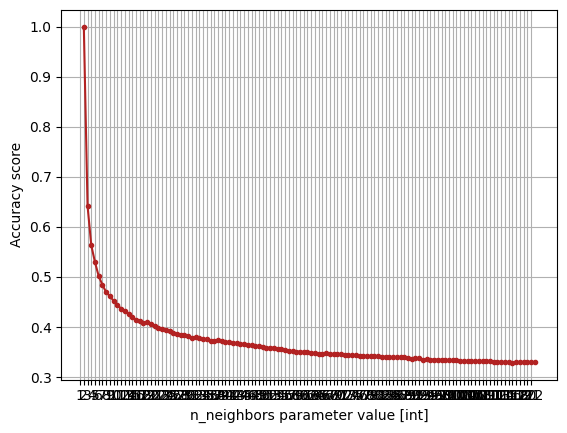

In [154]:
n_neighbors = k_nn_trials
scores = list()

for n in n_neighbors:
    print(f'Evaluating performances of KNN with n_neighbors = {n}')
    clf_to_tune = KNeighborsClassifier(n_neighbors=n, metric="precomputed", weights="uniform")
    clf_to_tune.fit(D_train, y_train)
    scores.append(clf_to_tune.score(D_train, y_train))
    print(f'Evaluating performances of KNN with n_neighbors = {n}, the score is: {clf_to_tune.score(D_train, y_train)}')

plt.figure()
plt.grid()
plt.errorbar(n_neighbors, scores, marker='.', color='firebrick')
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel("n_neighbors parameter value [int]")
plt.ylabel("Accuracy score")
plt.show()

We will use the 1-nn classifier with `weights=distance`.

The cross validation does not make any sense when we use the precomputed matrix. Because of this, we will do a repeated holdout with 5 folders, in this way, recomputing everytime the distance matrix. 

#### Repeated holdout for train set validation - partitioning and evaluation

In [142]:
from sklearn.model_selection import train_test_split

In [147]:
X_rh_train, X_rh_test, y_rh_train, y_rh_test = train_test_split(df_train[attributes].values, np.array(df_train['genre']), test_size=0.3, stratify=np.array(df_train['genre']))
print(len(X_rh_train), len(X_rh_test), len(y_rh_train), len(y_rh_test))

10500 4500 10500 4500


In [148]:
N = 3
err = 0
mean_acc = 0


for i in range(N):
    print(f'Holdout number {i}')
    # stratified holdout
    X_rh_train, X_rh_test, y_rh_train, y_rh_test = train_test_split(df_train[attributes].values, np.array(df_train['genre']), test_size=0.3, stratify=np.array(df_train['genre']))
    
    # normalize train set
    #performing minmax normalization 
    X_minmax_rh_train = scaler.fit_transform(X_rh_train)
    X_minmax_rh_test = scaler.fit_transform(X_rh_test)

    #Recompute distance matrices
    D_train_rh = pdist(X_minmax_rh_train, custom_dist_key)
    D_train_rh = squareform(D_train_rh)

    #D_test_rh = pdist(X_minmax_rh_test, custom_dist_key)
    #D_test_rh = squareform(D_test_rh)

    # initialize and fit classifier
    clf_rh = KNeighborsClassifier(n_neighbors=1, metric="precomputed", weights="distance")
    clf_rh.fit(D_train_rh, y_rh_train)

    # computing error
    acc = clf_rh.score(D_train_rh, y_rh_train)
    err += 1 - acc
    mean_acc += acc

print(f"Overall error estimate: {err/N}, Overall accuracy estimate: {mean_acc/N}")

Holdout number 0
Holdout number 1
Holdout number 2
Overall error estimate: 3.17460317460494e-05, Overall accuracy estimate: 0.999968253968254


In [165]:
y_pred_train = clf_rh.predict(D_train_rh)

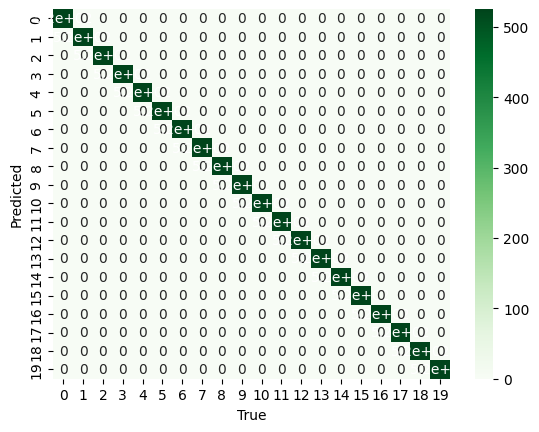

In [166]:
#Plotting the confusion matrix. Misclassifications are in off-diagonal terms
cf = confusion_matrix(y_rh_train, y_pred_train)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

The results seem so good... almost perfect. Where is the catch? 

#### Evaluation on complete train set

In [168]:
clf_full_train = KNeighborsClassifier(n_neighbors=1, metric="precomputed", weights="distance")
clf_full_train.fit(D_train, y_train)

y_full_train_predicted = clf_full_train.predict(D_train)
y_full_train_pred_proba = clf_full_train.predict_proba(D_train)

## Evaluation on test set

In [169]:
clf_test = KNeighborsClassifier(n_neighbors=1, metric="precomputed", weights="distance")
clf_test.fit(D_test, y_test)

y_test_predicted = clf_test.predict(D_test)
y_test_pred_proba = clf_test.predict_proba(D_test)

In [171]:
print(classification_report(y_train, y_full_train_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       750
           1       1.00      1.00      1.00       750
           2       1.00      1.00      1.00       750
           3       1.00      1.00      1.00       750
           4       1.00      1.00      1.00       750
           5       1.00      1.00      1.00       750
           6       1.00      1.00      1.00       750
           7       1.00      1.00      1.00       750
           8       1.00      1.00      1.00       750
           9       1.00      1.00      1.00       750
          10       1.00      1.00      1.00       750
          11       1.00      1.00      1.00       750
          12       1.00      1.00      1.00       750
          13       1.00      1.00      1.00       750
          14       1.00      1.00      1.00       750
          15       1.00      1.00      1.00       750
          16       1.00      1.00      1.00       750
          17       1.00    

In [170]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       250
           2       1.00      1.00      1.00       250
           3       1.00      1.00      1.00       250
           4       1.00      1.00      1.00       250
           5       1.00      1.00      1.00       250
           6       1.00      1.00      1.00       250
           7       1.00      1.00      1.00       250
           8       1.00      1.00      1.00       250
           9       1.00      1.00      1.00       250
          10       1.00      1.00      1.00       250
          11       1.00      1.00      1.00       250
          12       1.00      1.00      1.00       250
          13       1.00      1.00      1.00       250
          14       1.00      1.00      1.00       250
          15       1.00      1.00      1.00       250
          16       1.00      1.00      1.00       250
          17       1.00    

Those seems real performances, bc if we change the parameters, the performances changes. This suggest a trial for _clustering_.

In [173]:
y_test_pred_proba = clf_test.predict_proba(D_test)
y_train_pred_proba = clf_full_train.predict_proba(D_train)
print(f'Probabilities for test set: {y_test_pred_proba}')
print(f'Probabilities for train set: {y_train_pred_proba}')

Probabilities for test set: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Probabilities for train set: [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


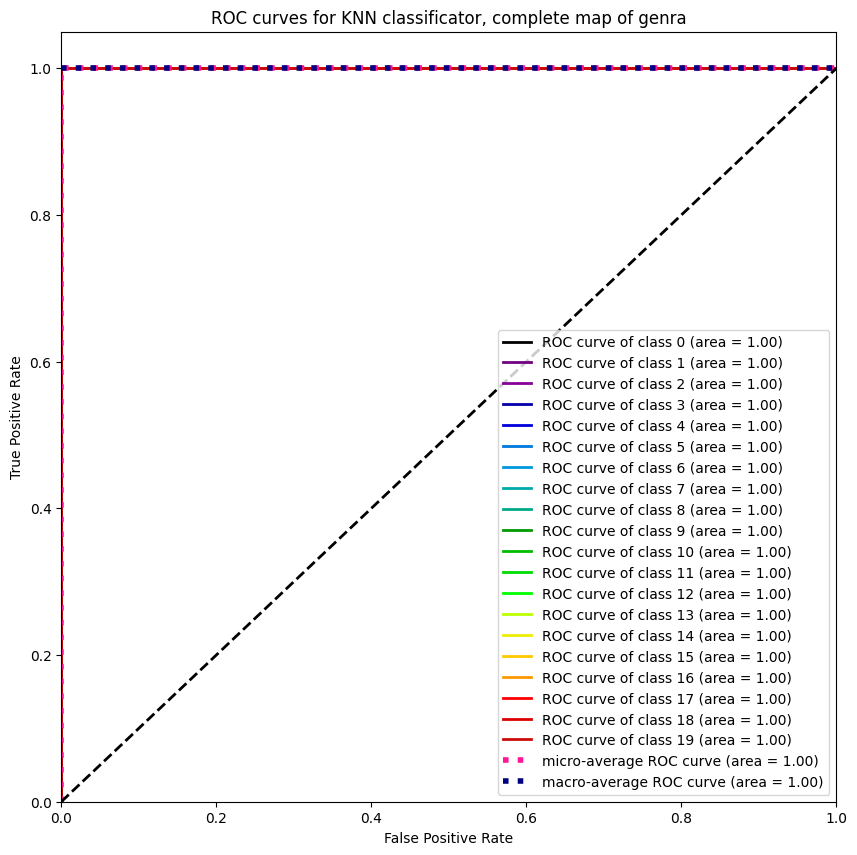

In [163]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
plot_roc(y_test, y_test_pred_proba, title='ROC curves for KNN classificator, complete map of genra', figsize=(10,10))
plt.show()